In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf

C:\Users\innovation\Anaconda3\envs\tfp3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.set_random_seed(42)

In [3]:
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [4]:
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector

In [5]:
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
from pylab import rcParams

In [6]:
import seaborn as sns

In [7]:
## loading the file:
path = 'nietzsche.txt'
# text = open(path).read().lower()
from nltk.corpus import gutenberg

text = ""
for fileid in ['shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']:
    text += "" +  gutenberg.raw(fileid)
print('corpus length:', len(text))

corpus length: 375542


In [8]:
# pre-processing
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 74


In [9]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 125168


In [10]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [11]:
## building the model
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [12]:
## training 
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 118909 samples, validate on 6259 samples
Epoch 1/20
118909/118909 [==============================] - 176s 1ms/step - loss: 3.0124 - acc: 0.1992 - val_loss: 2.7960 - val_acc: 0.2695
Epoch 2/20
118909/118909 [==============================] - 156s 1ms/step - loss: 2.7012 - acc: 0.2652 - val_loss: 2.6895 - val_acc: 0.2678
Epoch 3/20
118909/118909 [==============================] - 154s 1ms/step - loss: 2.6517 - acc: 0.2760 - val_loss: 2.8184 - val_acc: 0.2611
Epoch 4/20
118909/118909 [==============================] - 171s 1ms/step - loss: 2.6249 - acc: 0.2813 - val_loss: 2.9565 - val_acc: 0.2329
Epoch 5/20
118909/118909 [==============================] - 173s 1ms/step - loss: 2.6146 - acc: 0.2827 - val_loss: 2.7147 - val_acc: 0.2528
Epoch 6/20
118909/118909 [==============================] - 156s 1ms/step - loss: 2.6074 - acc: 0.2853 - val_loss: 2.6664 - val_acc: 0.2836
Epoch 7/20
118909/118909 [==============================] - 153s 1ms/step - loss: 2.5964 - acc: 0.2845 - val_l

In [13]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [14]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

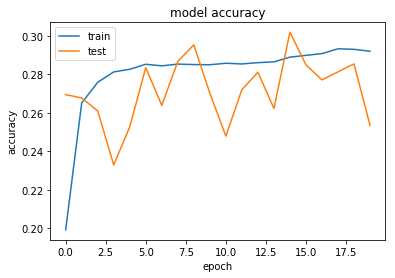

In [15]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

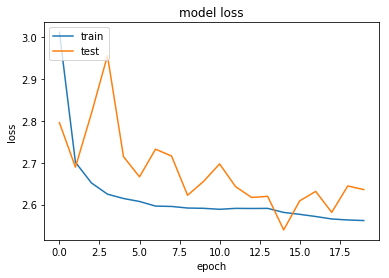

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [17]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [18]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [19]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [20]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [32]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!",
    text[:110],
    "My name is Khan. I drink water and I am not a terrorist. Please may I come in. To have a chat with you.",
    text[:120]
]

In [35]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 6))
    print()

it is not a lack of love, but a lack of 
['vs ', 'win ', 'so ', 'be ', 'to ', 'o ']

that which does not kill us makes us str
['e ', 'os ', 'in ', 'as ', 're ', 'us ']

i'm not upset that you lied to me, i'm u
[' vs ', 'r ', 'u ', 'n ', 'll ', 'f ']

C:\Users\innovation\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until




and those who were seen dancing were tho
['s ', 'r ', 'n ', 't ', 'u ', ' vs ']

it is hard enough to remember my opinion
[' vs ', 's ', 'e ', 'd ', 't ', 'g ']

[the tragedie of julius caesar by willia
['s ', 'r ', 'n ', 't ', 'll ', ' vs ']

my name is khan. i drink water and i am 
['vs ', 'win ', 'so ', 'be ', 'to ', 'o ']

[the tragedie of julius caesar by willia
['s ', 'r ', 'n ', 't ', 'll ', ' vs ']



In [23]:
text[:100]

'[The Tragedie of Julius Caesar by William Shakespeare 1599]\n\n\nActus Primus. Scoena Prima.\n\nEnter Fla'